In [2]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns

from tqdm import tqdm
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [3]:
data_doh = pd.read_csv('0.7doh.csv', delimiter=',')
data_nodoh = pd.read_csv('0.7nodoh.csv', delimiter=',')
train1 = pd.concat([data_doh,data_nodoh])
train1.columns
train = train1.drop(labels = ['TimeStamp','SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort','Duration'], axis = 1)
train.columns

Index(['FlowBytesSent', 'FlowSentRate', 'FlowBytesReceived',
       'FlowReceivedRate', 'PacketLengthVariance',
       'PacketLengthStandardDeviation', 'PacketLengthMean',
       'PacketLengthMedian', 'PacketLengthMode', 'PacketLengthSkewFromMedian',
       'PacketLengthSkewFromMode', 'PacketLengthCoefficientofVariation',
       'PacketTimeVariance', 'PacketTimeStandardDeviation', 'PacketTimeMean',
       'PacketTimeMedian', 'PacketTimeMode', 'PacketTimeSkewFromMedian',
       'PacketTimeSkewFromMode', 'PacketTimeCoefficientofVariation',
       'ResponseTimeTimeVariance', 'ResponseTimeTimeStandardDeviation',
       'ResponseTimeTimeMean', 'ResponseTimeTimeMedian',
       'ResponseTimeTimeMode', 'ResponseTimeTimeSkewFromMedian',
       'ResponseTimeTimeSkewFromMode',
       'ResponseTimeTimeCoefficientofVariation', 'Label'],
      dtype='object')

In [4]:
null = train.isnull()
print(train.isnull().any().any())
print(null.sum())
train['ResponseTimeTimeMedian'] = train['ResponseTimeTimeMedian'].fillna(0)
train['ResponseTimeTimeSkewFromMedian'] = train['ResponseTimeTimeSkewFromMedian'].fillna(0)
null = train.isnull()
print("New: ", train.isnull().any().any())
print("New: ", null.sum())

True
FlowBytesSent                                0
FlowSentRate                                 0
FlowBytesReceived                            0
FlowReceivedRate                             0
PacketLengthVariance                         0
PacketLengthStandardDeviation                0
PacketLengthMean                             0
PacketLengthMedian                           0
PacketLengthMode                             0
PacketLengthSkewFromMedian                   0
PacketLengthSkewFromMode                     0
PacketLengthCoefficientofVariation           0
PacketTimeVariance                           0
PacketTimeStandardDeviation                  0
PacketTimeMean                               0
PacketTimeMedian                             0
PacketTimeMode                               0
PacketTimeSkewFromMedian                     0
PacketTimeSkewFromMode                       0
PacketTimeCoefficientofVariation             0
ResponseTimeTimeVariance                     0
Response

In [5]:
data_doh1 = pd.read_csv('0.3doh.csv', delimiter=',')
data_nodoh1 = pd.read_csv('0.3nodoh.csv', delimiter=',')
test1 = pd.concat([data_doh1,data_nodoh1])
test1.columns
test = test1.drop(labels = ['TimeStamp','SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort','Duration'], axis = 1)
test.columns

Index(['FlowBytesSent', 'FlowSentRate', 'FlowBytesReceived',
       'FlowReceivedRate', 'PacketLengthVariance',
       'PacketLengthStandardDeviation', 'PacketLengthMean',
       'PacketLengthMedian', 'PacketLengthMode', 'PacketLengthSkewFromMedian',
       'PacketLengthSkewFromMode', 'PacketLengthCoefficientofVariation',
       'PacketTimeVariance', 'PacketTimeStandardDeviation', 'PacketTimeMean',
       'PacketTimeMedian', 'PacketTimeMode', 'PacketTimeSkewFromMedian',
       'PacketTimeSkewFromMode', 'PacketTimeCoefficientofVariation',
       'ResponseTimeTimeVariance', 'ResponseTimeTimeStandardDeviation',
       'ResponseTimeTimeMean', 'ResponseTimeTimeMedian',
       'ResponseTimeTimeMode', 'ResponseTimeTimeSkewFromMedian',
       'ResponseTimeTimeSkewFromMode',
       'ResponseTimeTimeCoefficientofVariation', 'Label'],
      dtype='object')

In [6]:
null = test.isnull()
print(train.isnull().any().any())
print(null.sum())
test['ResponseTimeTimeMedian'] = test['ResponseTimeTimeMedian'].fillna(0)
test['ResponseTimeTimeSkewFromMedian'] = test['ResponseTimeTimeSkewFromMedian'].fillna(0)
null = test.isnull()
print("New: ", test.isnull().any().any())
print("New: ", null.sum())

False
FlowBytesSent                                0
FlowSentRate                                 0
FlowBytesReceived                            0
FlowReceivedRate                             0
PacketLengthVariance                         0
PacketLengthStandardDeviation                0
PacketLengthMean                             0
PacketLengthMedian                           0
PacketLengthMode                             0
PacketLengthSkewFromMedian                   0
PacketLengthSkewFromMode                     0
PacketLengthCoefficientofVariation           0
PacketTimeVariance                           0
PacketTimeStandardDeviation                  0
PacketTimeMean                               0
PacketTimeMedian                             0
PacketTimeMode                               0
PacketTimeSkewFromMedian                     0
PacketTimeSkewFromMode                       0
PacketTimeCoefficientofVariation             0
ResponseTimeTimeVariance                     0
Respons

In [7]:
train = train[~train.drop('Label', axis = 1).duplicated()]
test = test[~test.drop('Label', axis = 1).duplicated()]
X = pd.DataFrame(train.drop("Label", axis = 1))

lencoder = LabelEncoder()
y = pd.DataFrame(lencoder.fit_transform(train['Label']), columns=['Label'])

In [8]:
 params = { 
        'objective': 'binary', 
        'num_class' : 1, 
        'metric': 'binary_logloss' 
    } 

In [9]:
print("训练集特征列:", train.columns)
print("测试集特征列:", test.columns)
print("训练数据特征数量:", X.shape[1])
print("测试数据特征数量:", test.shape[1])

训练集特征列: Index(['FlowBytesSent', 'FlowSentRate', 'FlowBytesReceived',
       'FlowReceivedRate', 'PacketLengthVariance',
       'PacketLengthStandardDeviation', 'PacketLengthMean',
       'PacketLengthMedian', 'PacketLengthMode', 'PacketLengthSkewFromMedian',
       'PacketLengthSkewFromMode', 'PacketLengthCoefficientofVariation',
       'PacketTimeVariance', 'PacketTimeStandardDeviation', 'PacketTimeMean',
       'PacketTimeMedian', 'PacketTimeMode', 'PacketTimeSkewFromMedian',
       'PacketTimeSkewFromMode', 'PacketTimeCoefficientofVariation',
       'ResponseTimeTimeVariance', 'ResponseTimeTimeStandardDeviation',
       'ResponseTimeTimeMean', 'ResponseTimeTimeMedian',
       'ResponseTimeTimeMode', 'ResponseTimeTimeSkewFromMedian',
       'ResponseTimeTimeSkewFromMode',
       'ResponseTimeTimeCoefficientofVariation', 'Label'],
      dtype='object')
测试集特征列: Index(['FlowBytesSent', 'FlowSentRate', 'FlowBytesReceived',
       'FlowReceivedRate', 'PacketLengthVariance',
       'Packet

In [10]:
test_preds = None
train_rmse = 0
val_rmse = 0
n_splits = 10
test['Label'] = lencoder.fit_transform(test['Label'])
train['Label'] = lencoder.fit_transform(train['Label'])
test = test.drop(["Label"], axis=1)

model =  LGBMClassifier(**params)

skf = StratifiedKFold(n_splits = n_splits, shuffle = True,  random_state = 0)

for tr_index , val_index in tqdm(skf.split(X.values , y.values), total=skf.get_n_splits(), desc="k-fold"):

    x_train_o, x_val_o = X.iloc[tr_index] , X.iloc[val_index]
    y_train_o, y_val_o = y.iloc[tr_index] , y.iloc[val_index]

    eval_set = [(x_val_o, y_val_o)]

    model.fit(x_train_o, y_train_o, eval_set = eval_set, early_stopping_rounds=100, verbose=False)

    train_preds = model.predict(x_train_o)
    train_rmse += mean_squared_error(y_train_o ,train_preds , squared = False)

    val_preds = model.predict(x_val_o)
    val_rmse += mean_squared_error(y_val_o , val_preds , squared = False)
    if test_preds is None:
        test_preds = model.predict_proba(test.values)[:, 1]  # 获取正类别的预测概率
    else:
        test_preds += model.predict_proba(test.values)[:, 1] 

print(f"\nAverage Training RMSE : {train_rmse / n_splits}")
print(f"Average Validation RMSE : {val_rmse / n_splits}\n")

test_preds /= n_splits


k-fold: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.82s/it]


Average Training RMSE : 0.09307768993962955
Average Validation RMSE : 0.09501095849010249



In [11]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test)

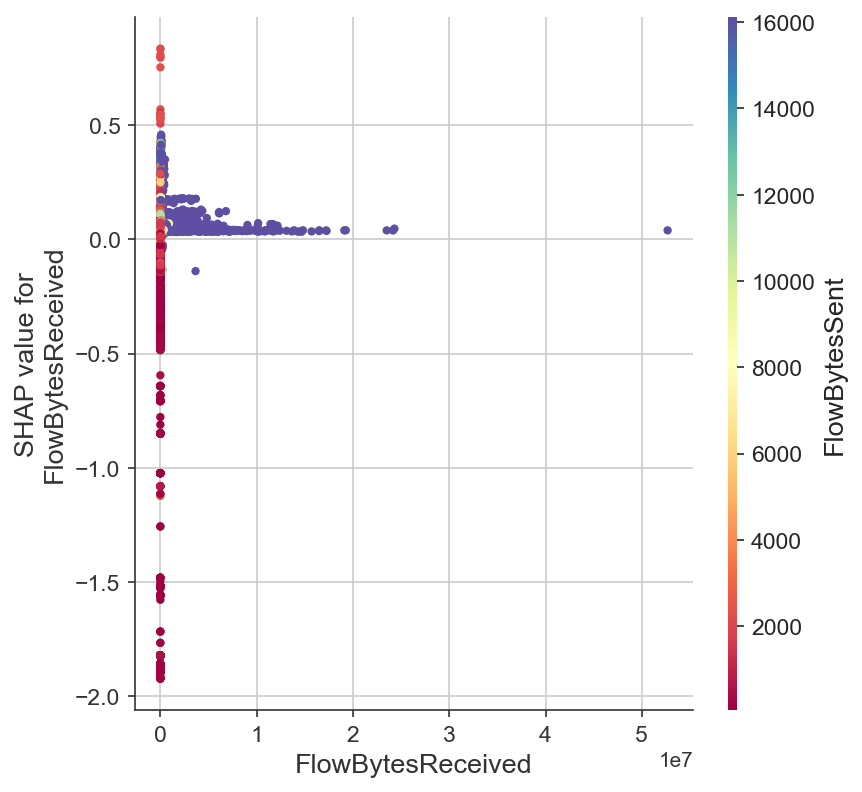

In [19]:
fig, ax2= plt.subplots(figsize=(6,6),dpi=150)

shp_plt = shap.dependence_plot("FlowBytesReceived", shap_values[0],test,ax=ax2, interaction_index='FlowBytesSent', cmap=plt.get_cmap('Spectral'))

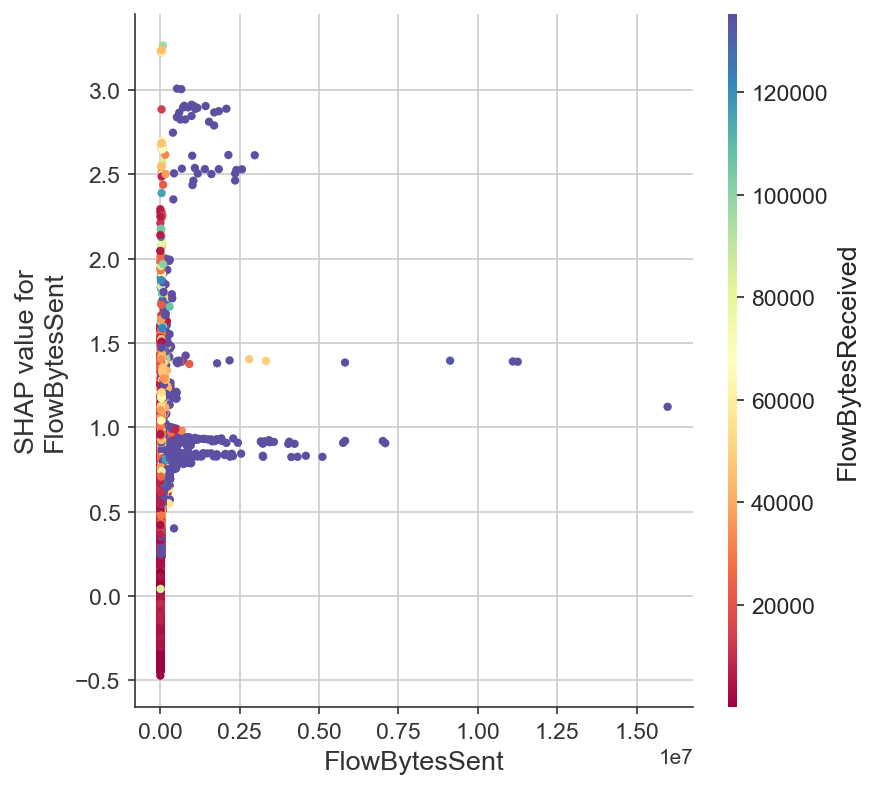

In [20]:
fig, ax2= plt.subplots(figsize=(6,6),dpi=150)

shp_plt = shap.dependence_plot("FlowBytesSent", shap_values[0],test,ax=ax2, interaction_index='FlowBytesReceived', cmap=plt.get_cmap('Spectral'))

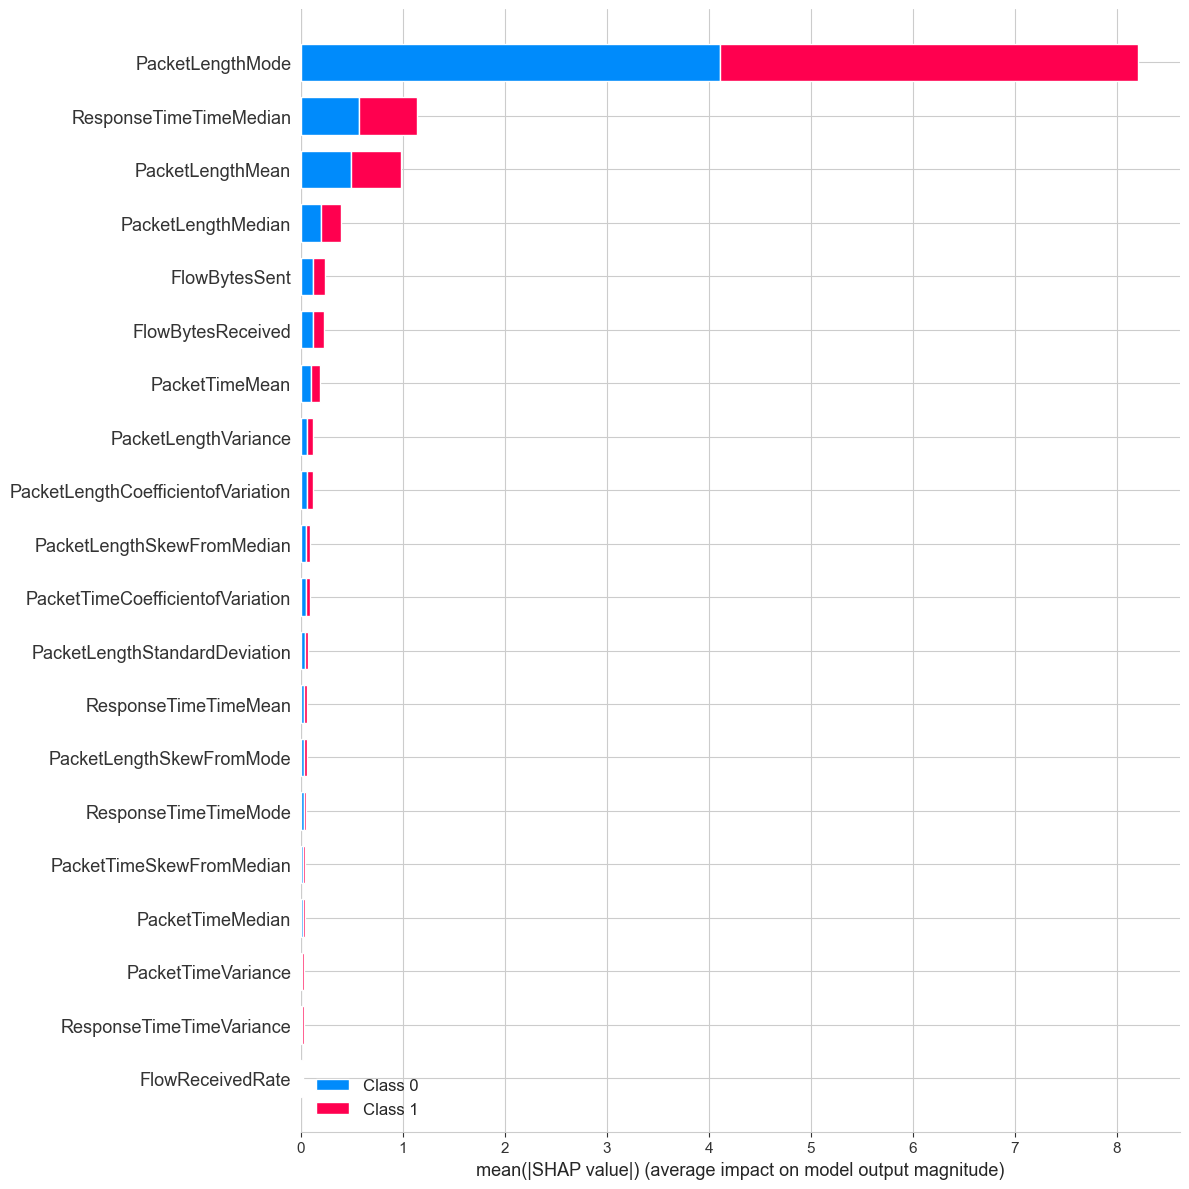

In [12]:
shap.summary_plot(shap_values, X, plot_type="bar",plot_size=(12,12))

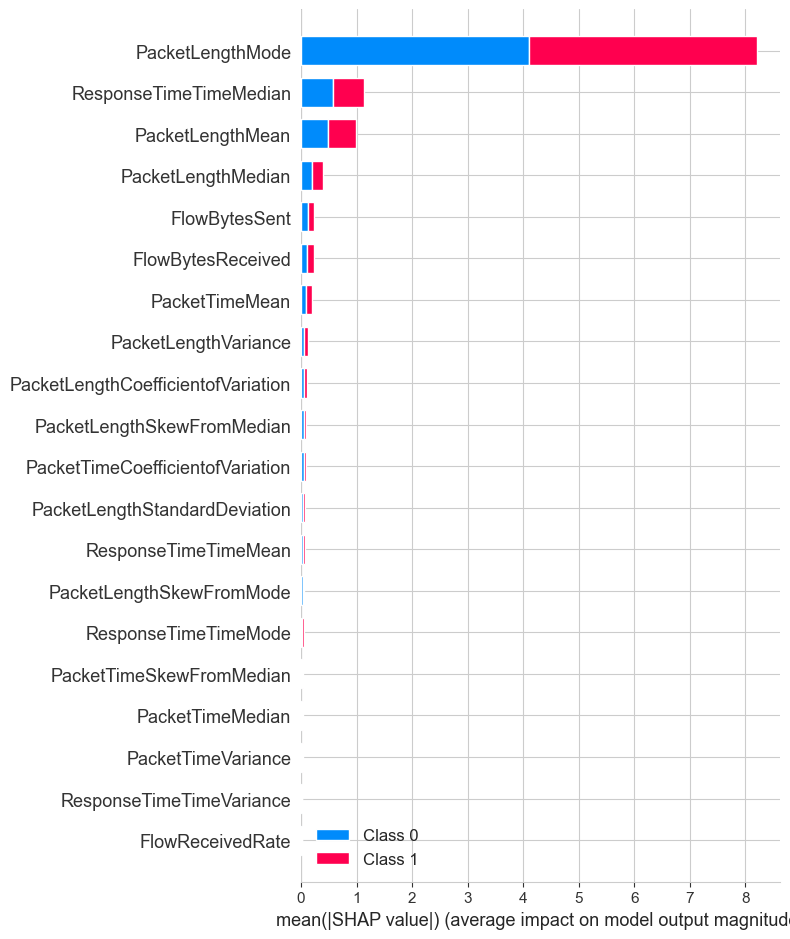

In [13]:
shap.summary_plot(shap_values, X)

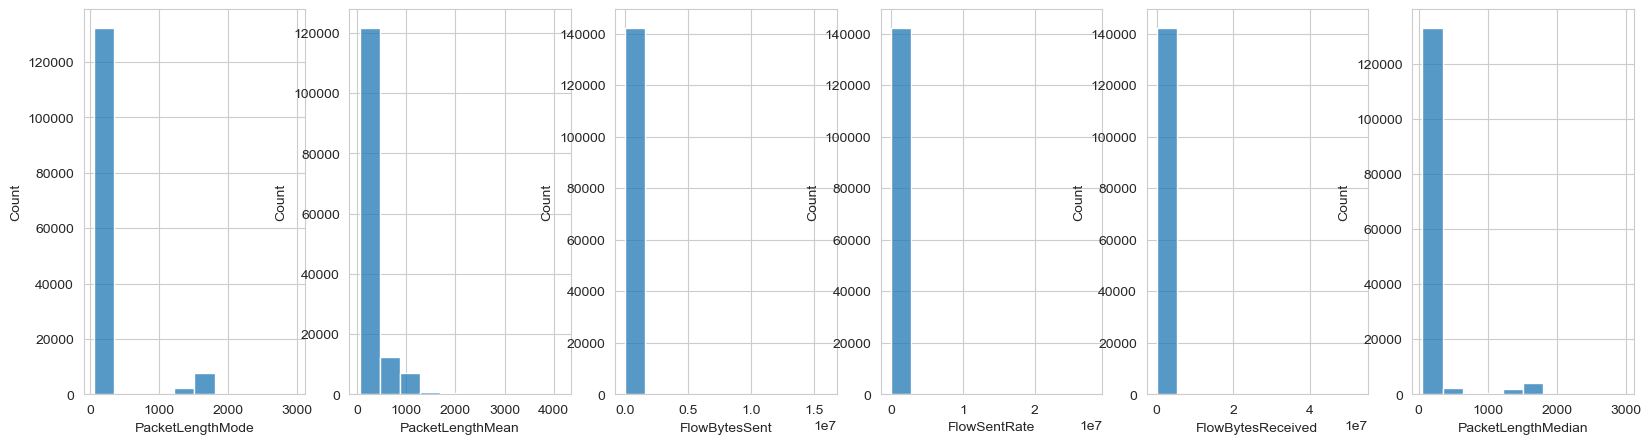

In [14]:
selected_features = ["PacketLengthMode", "PacketLengthMean", "FlowBytesSent", "FlowSentRate", "FlowBytesReceived", "PacketLengthMedian"]

plt.figure(figsize=(20,5))
c = 1
for feat in selected_features:
    plt.subplot(1, 6, c)
    sns.histplot(x = feat, data = test, bins=10)
    c = c + 1    
plt.show()

In [15]:
test[selected_features].describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

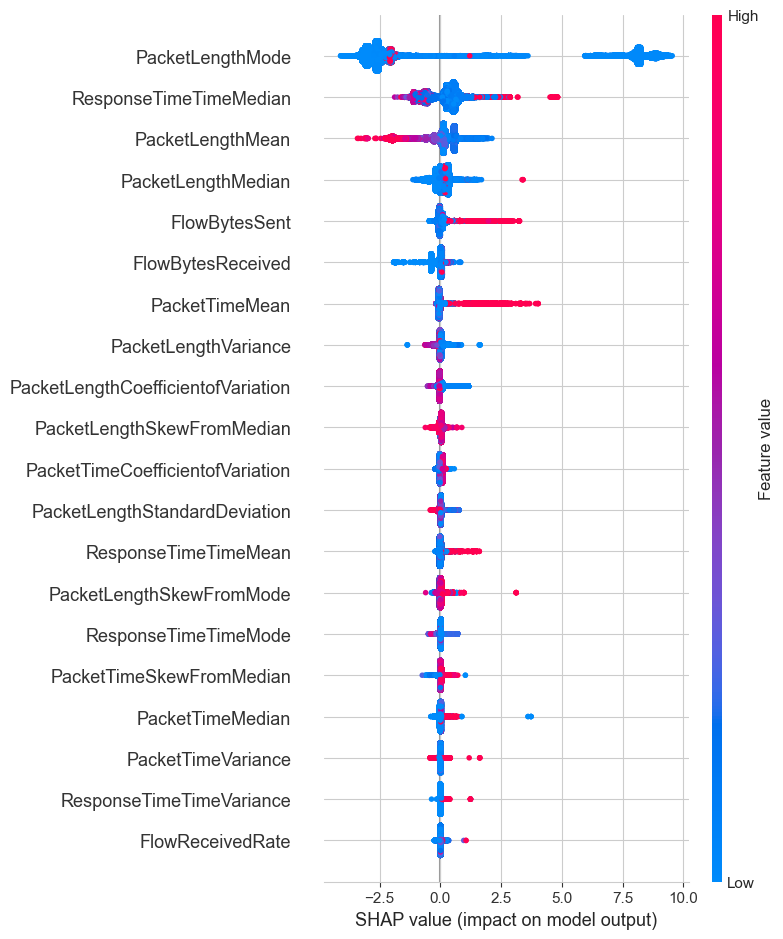

In [16]:
shap.summary_plot(shap_values[0], test)

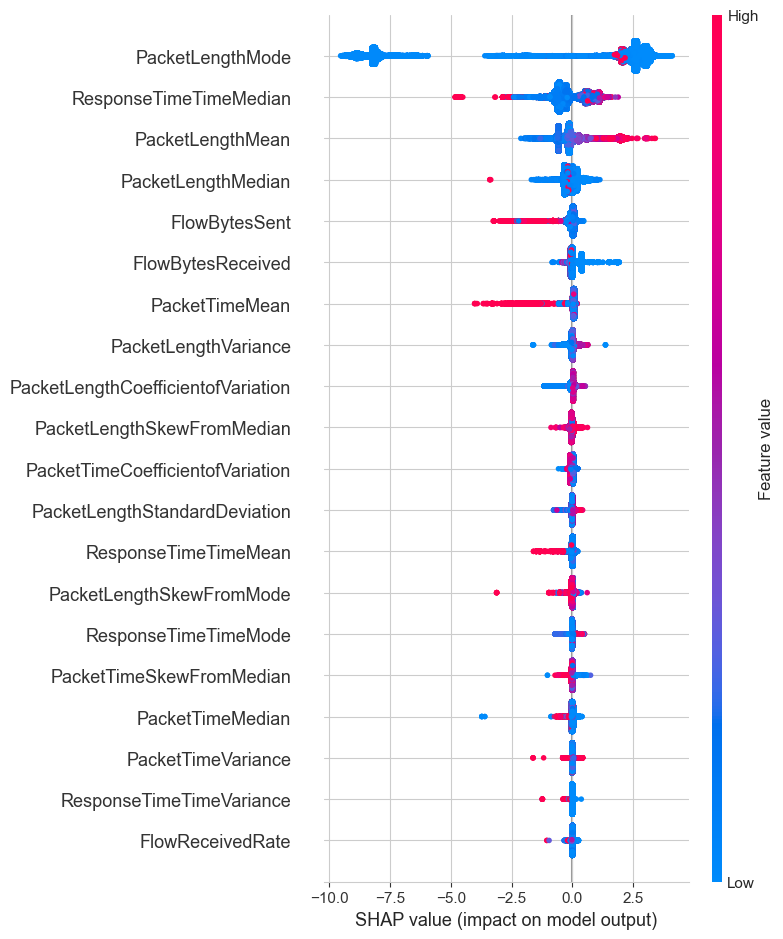

In [17]:
shap.summary_plot(shap_values[1], test)

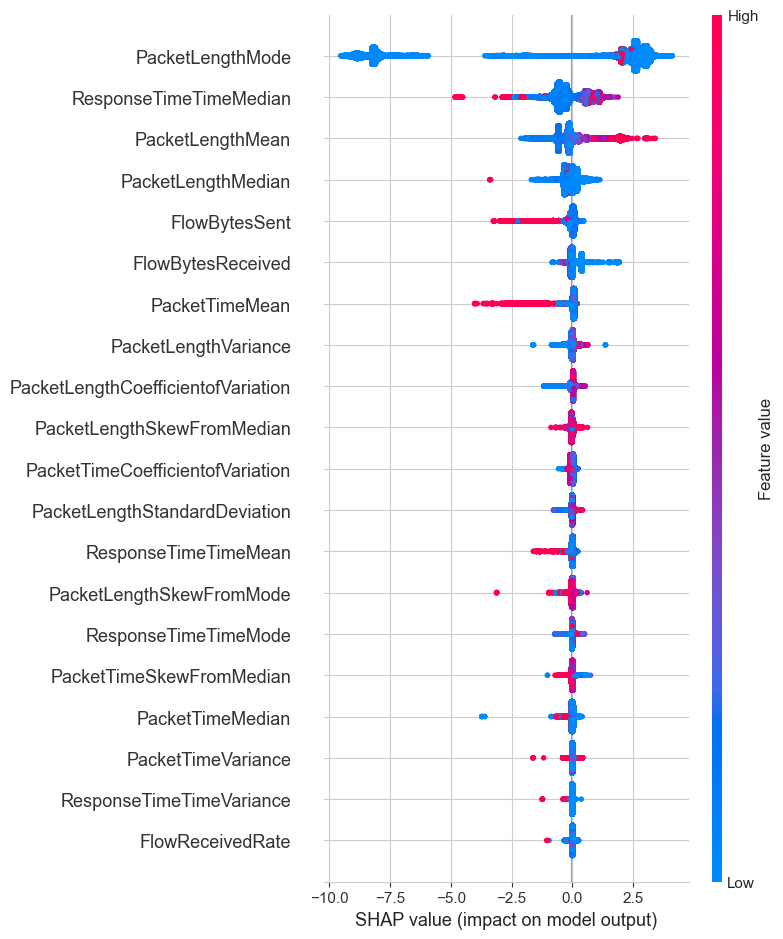

In [18]:
shap.summary_plot(shap_values[1], test)

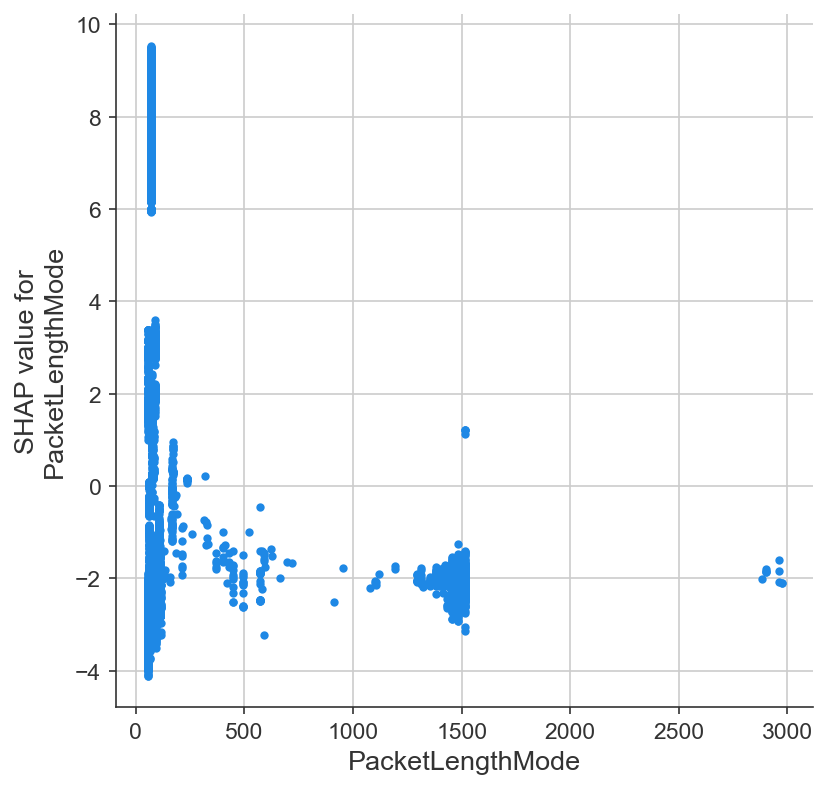

In [19]:
fig, ax1= plt.subplots(figsize=(6,6),dpi=150)

shp_plt = shap.dependence_plot("PacketLengthMode", shap_values[0],test,ax=ax1, interaction_index=None)

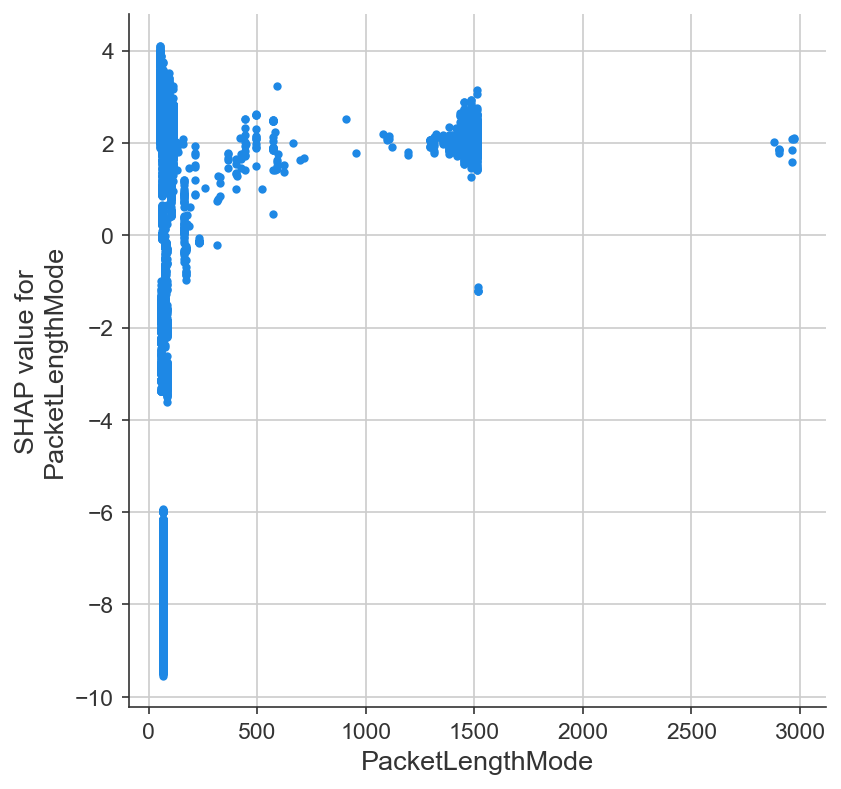

In [20]:
fig, ax1= plt.subplots(figsize=(6,6),dpi=150)

shp_plt = shap.dependence_plot("PacketLengthMode", shap_values[1],test,ax=ax1, interaction_index=None)

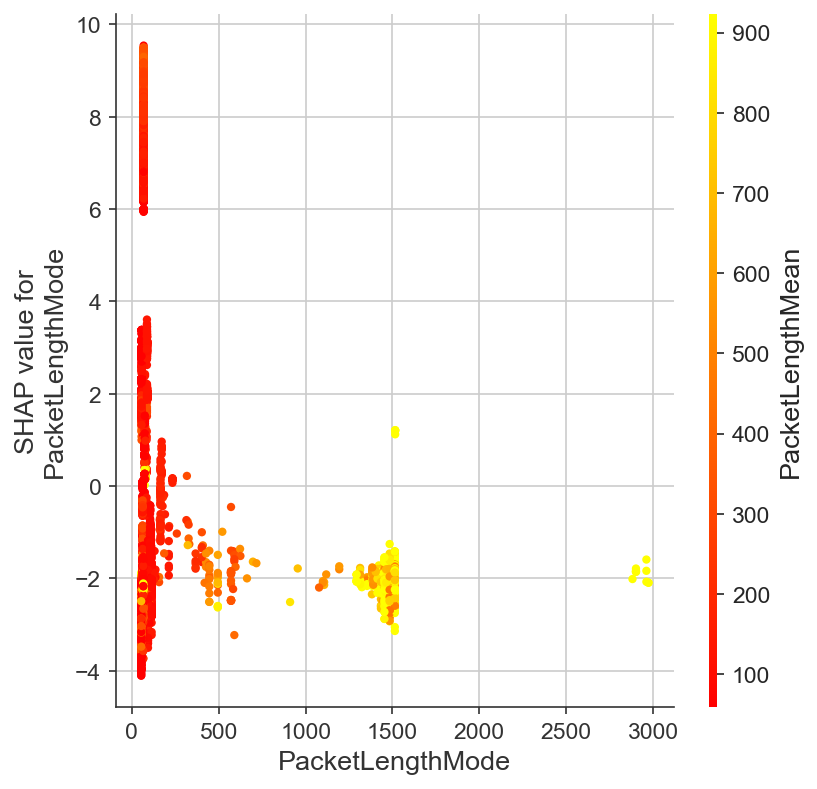

In [21]:
fig, ax1= plt.subplots(figsize=(6,6),dpi=150)

shp_plt = shap.dependence_plot("PacketLengthMode", shap_values[0],test,ax=ax1, cmap=plt.get_cmap('autumn'))

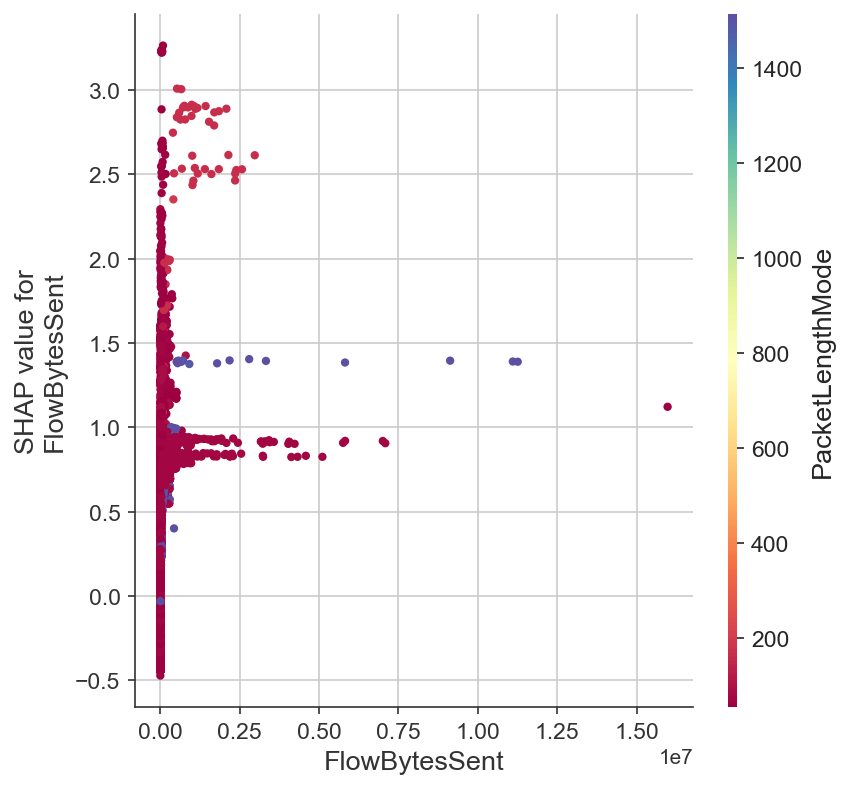

In [22]:
fig, ax2= plt.subplots(figsize=(6,6),dpi=150)

shp_plt = shap.dependence_plot("FlowBytesSent", shap_values[0],test,ax=ax2, interaction_index='PacketLengthMode', cmap=plt.get_cmap('Spectral'))

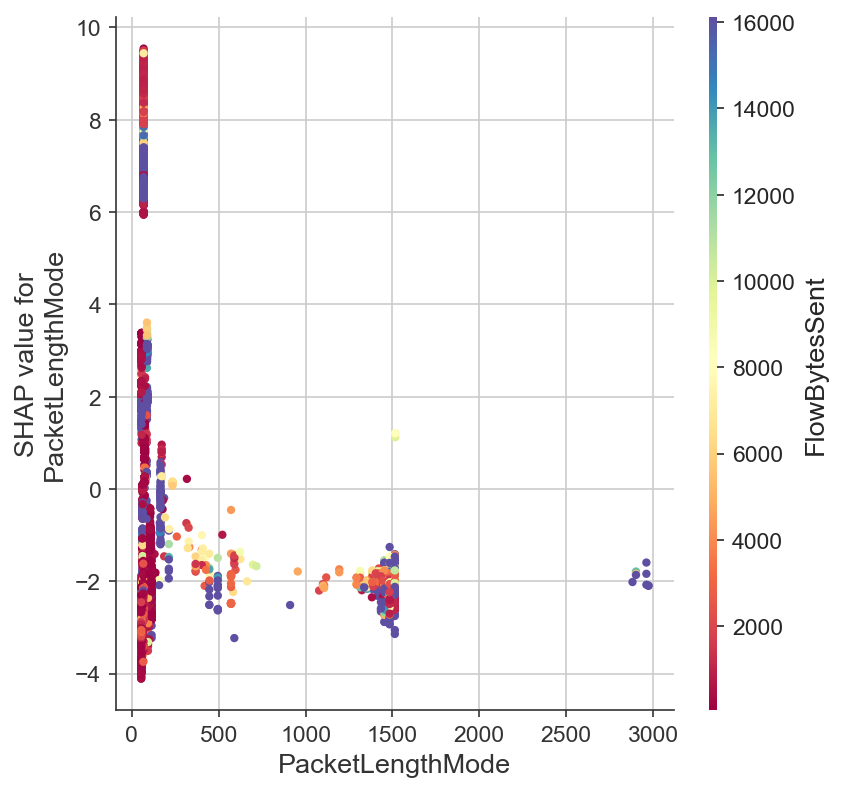

In [23]:
fig, ax2= plt.subplots(figsize=(6,6),dpi=150)

shp_plt = shap.dependence_plot("PacketLengthMode", shap_values[0],test,ax=ax2, interaction_index='FlowBytesSent', cmap=plt.get_cmap('Spectral'))

In [24]:
print(f'Expected Value-Base Value: {explainer.expected_value}')

Expected Value-Base Value: [-3.397133921782203, 3.397133921782203]


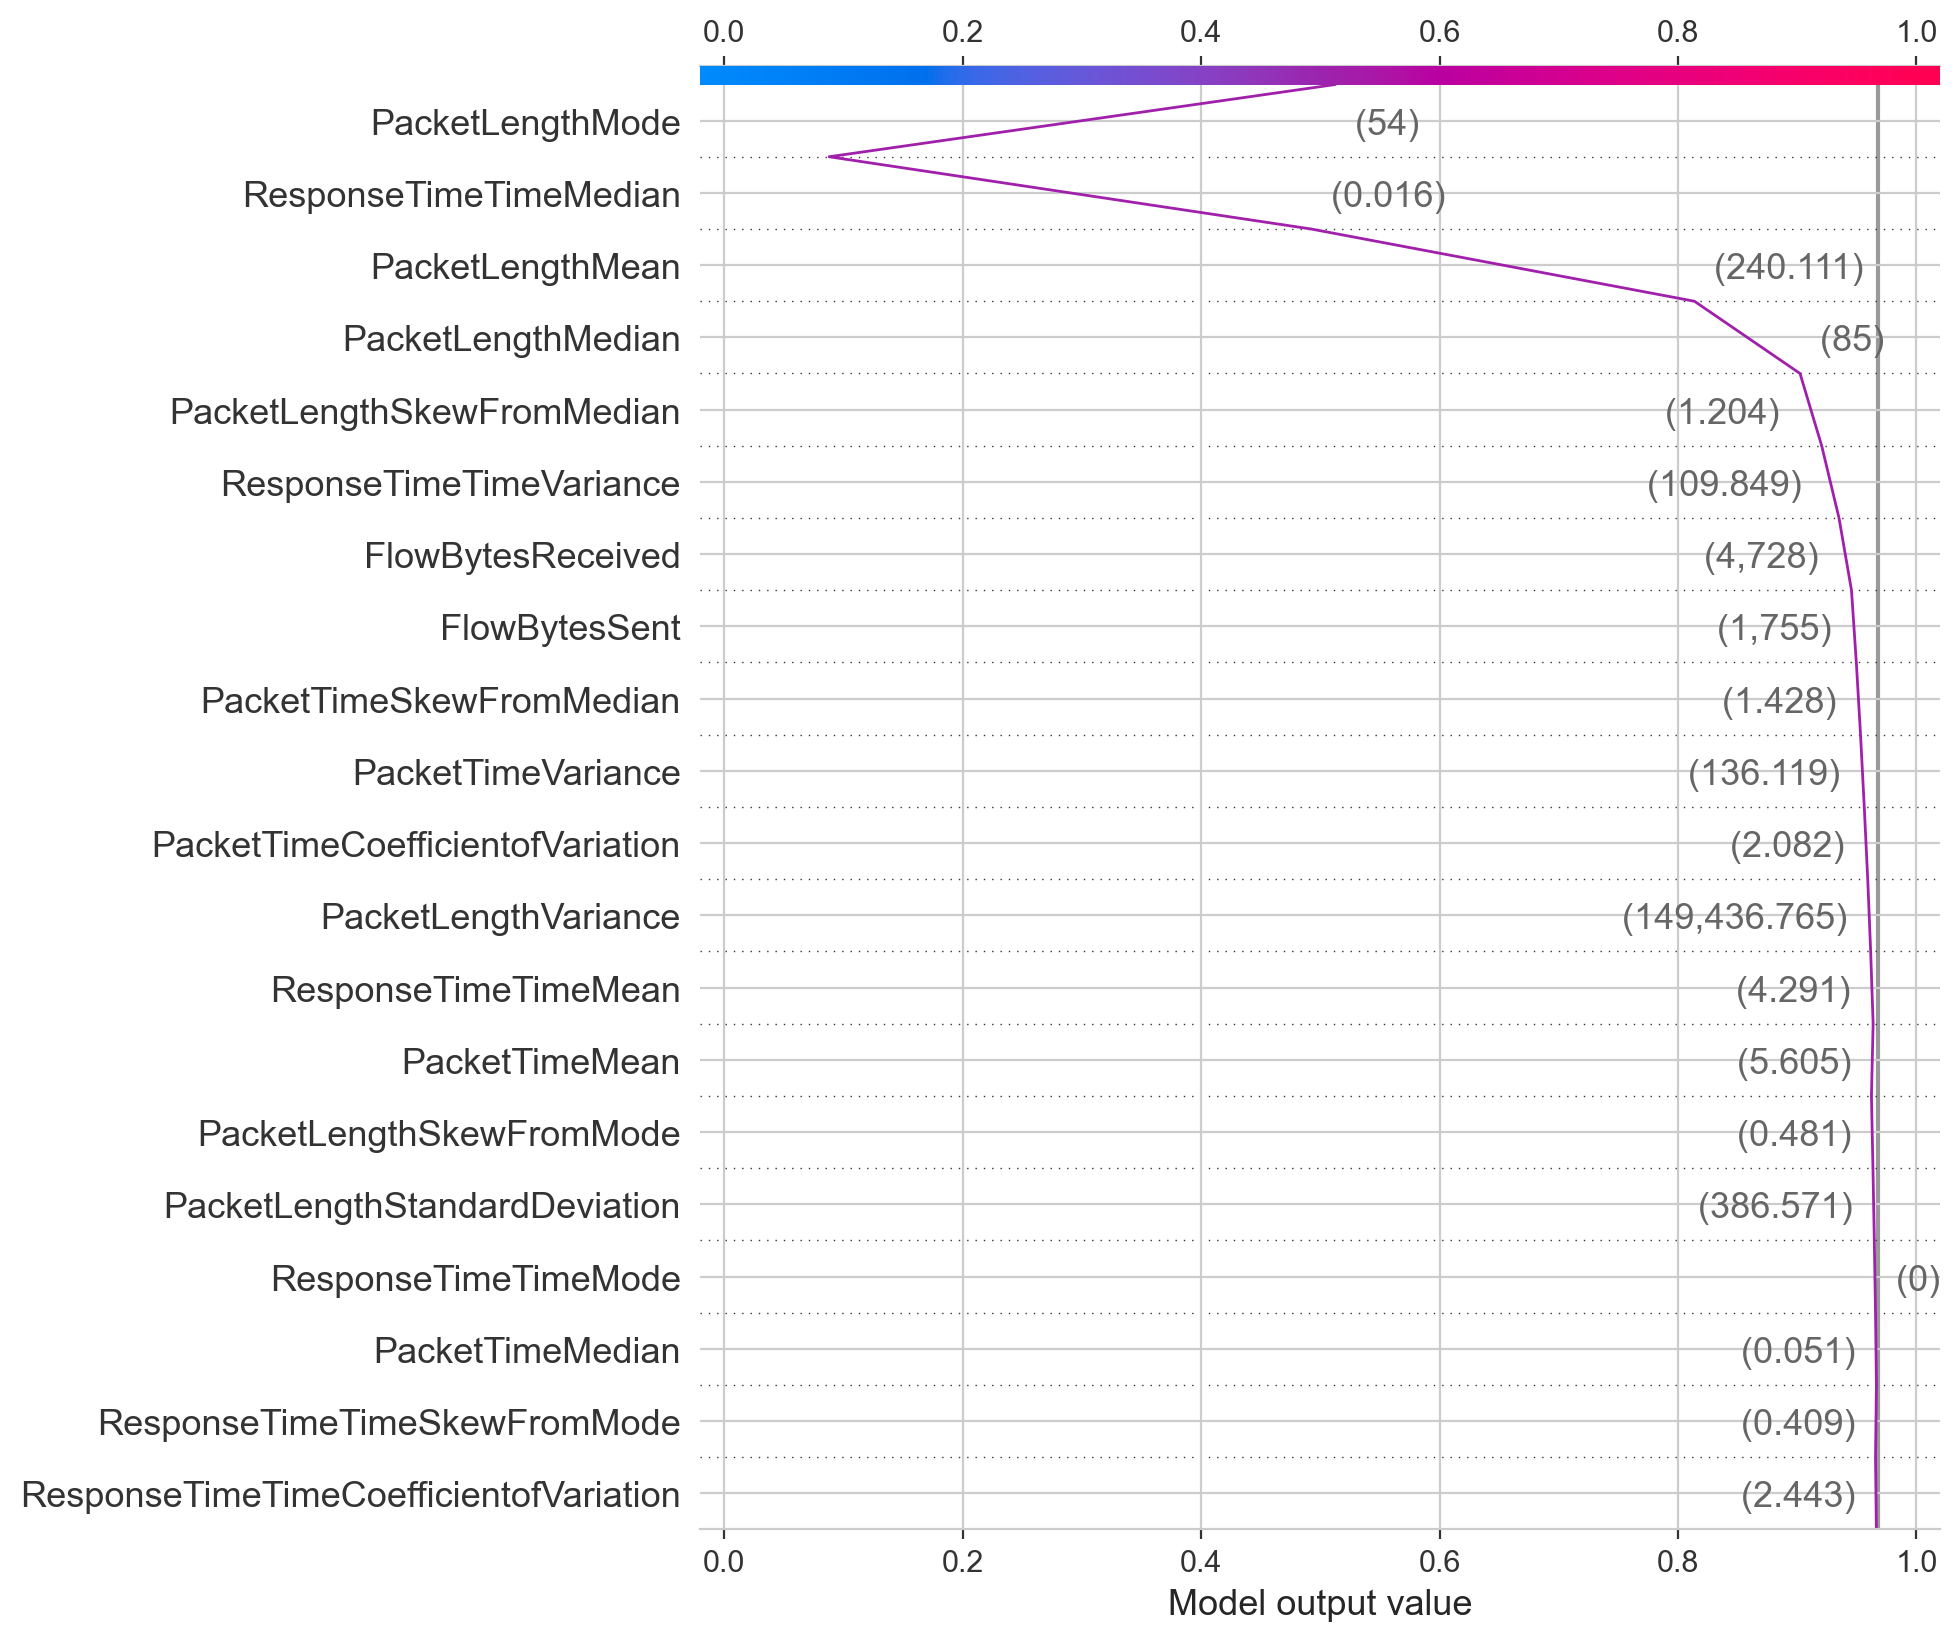

In [25]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=200)
sample_idx = 15  # 样本索引
ax_2 = shap.decision_plot(explainer.expected_value[1], shap_values[1][sample_idx], test.iloc[[sample_idx]], link="logit")

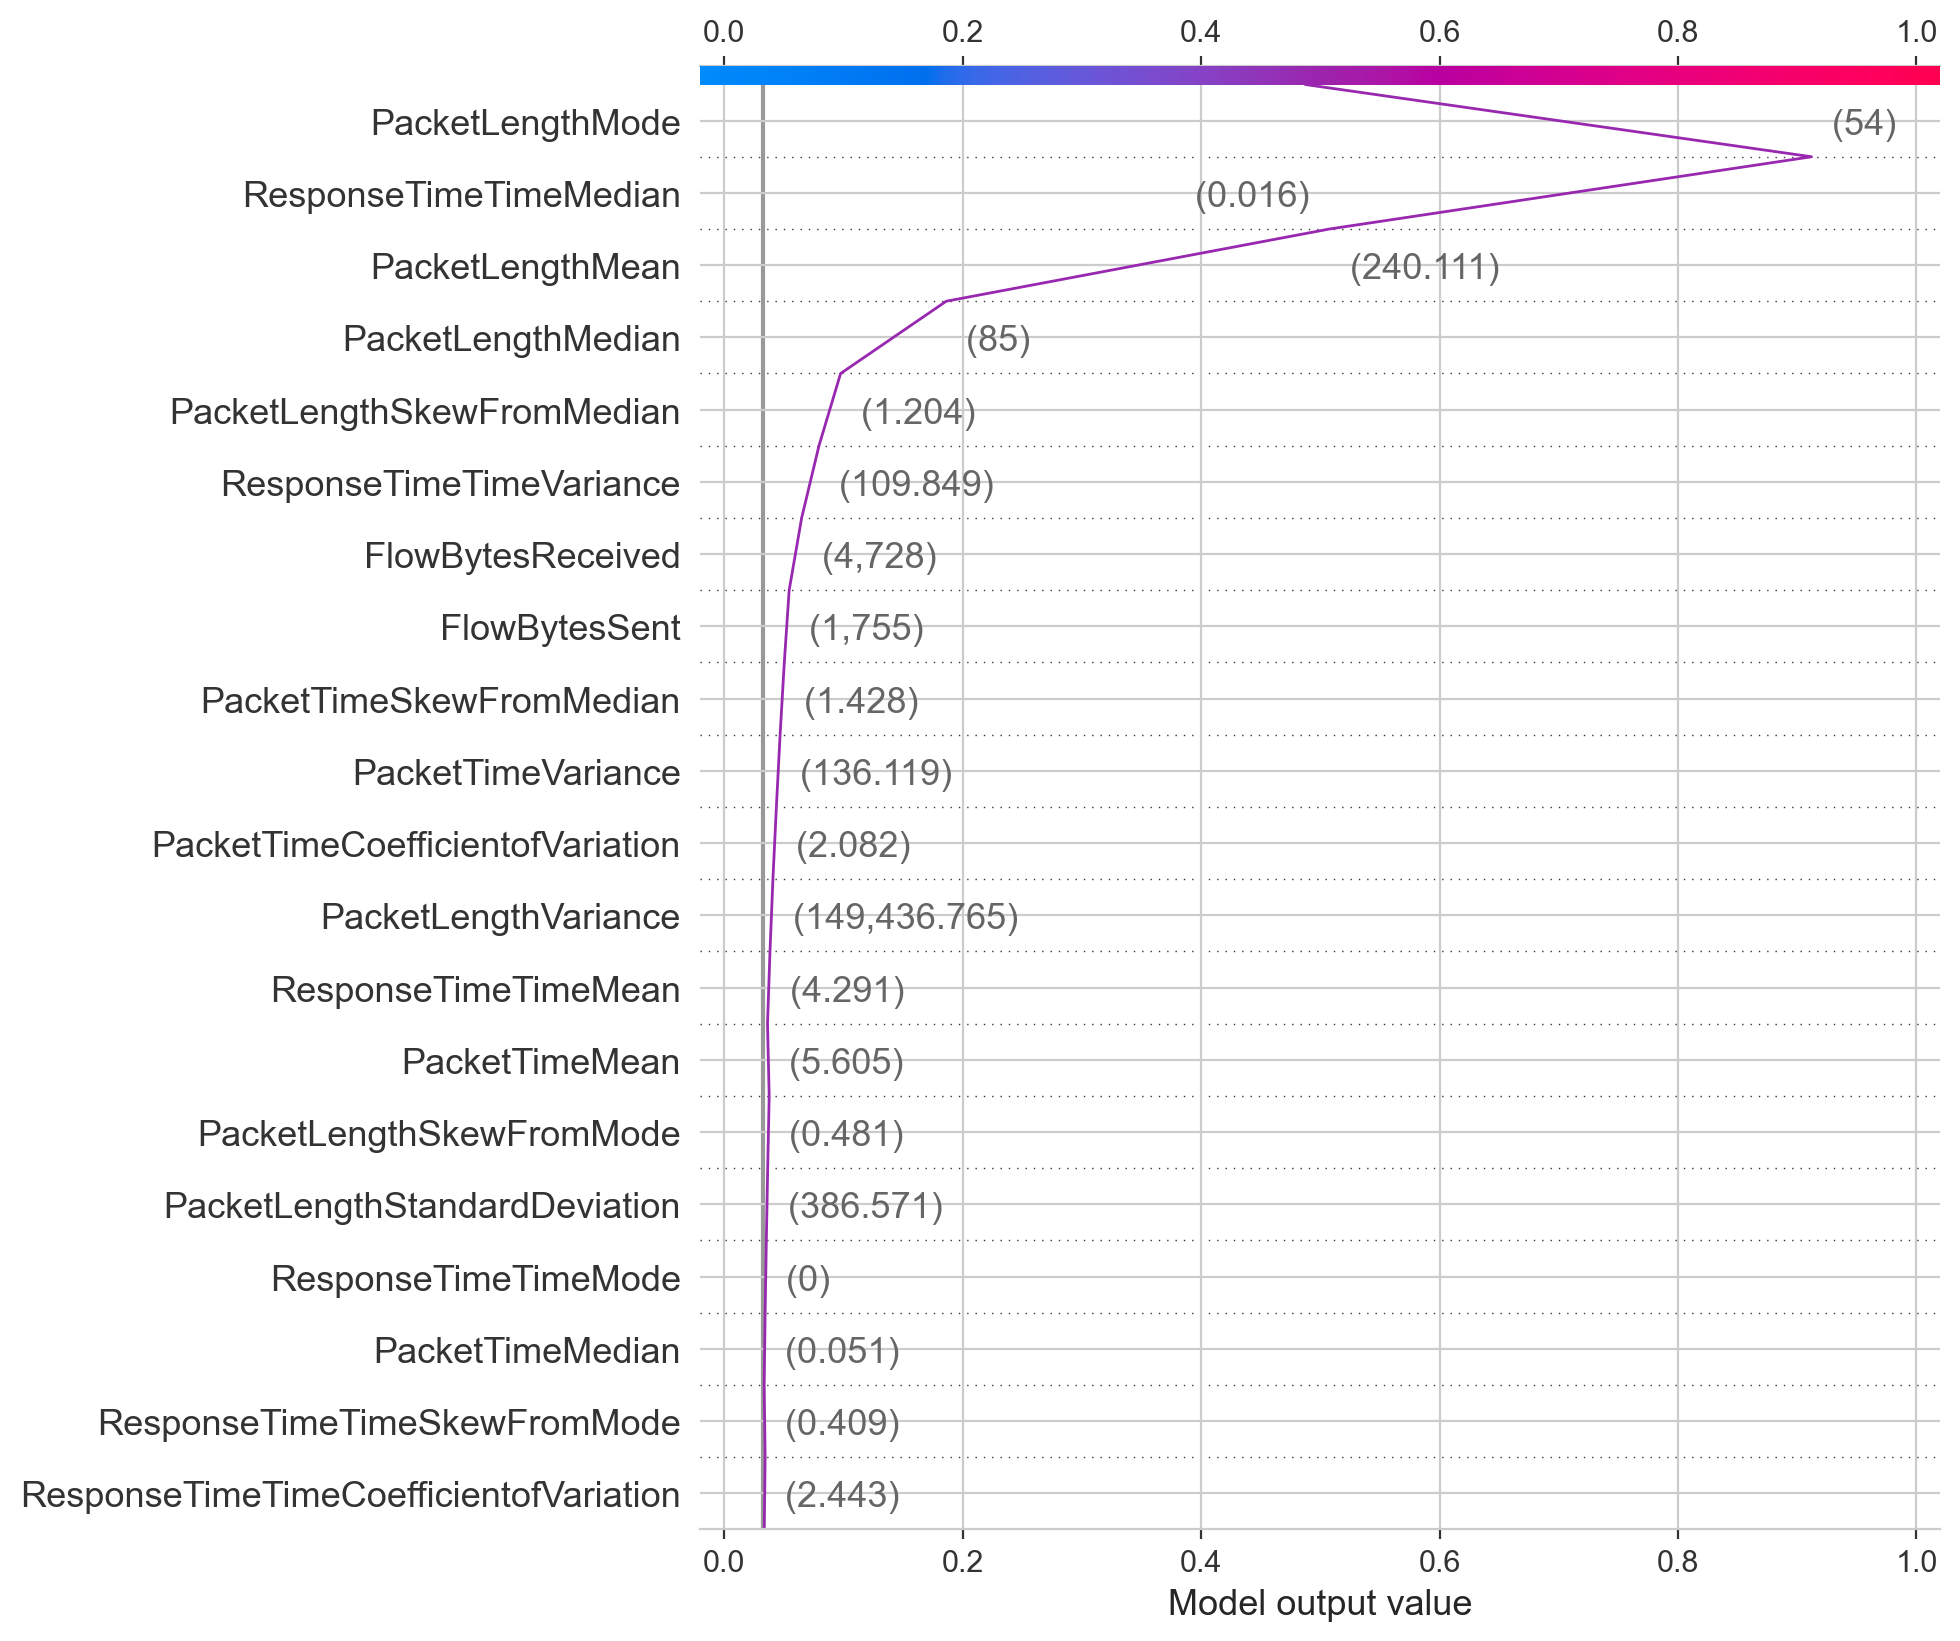

In [26]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=200)
sample_idx = 15  # 样本索引
ax_2 = shap.decision_plot(explainer.expected_value[0], shap_values[0][sample_idx], test.iloc[[sample_idx]], link="logit")

In [12]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][:50], test.iloc[:50],link= "logit")

In [14]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0][:50], test.iloc[:50],link= "logit")

In [13]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][15], test.iloc[[15]],link= "logit")

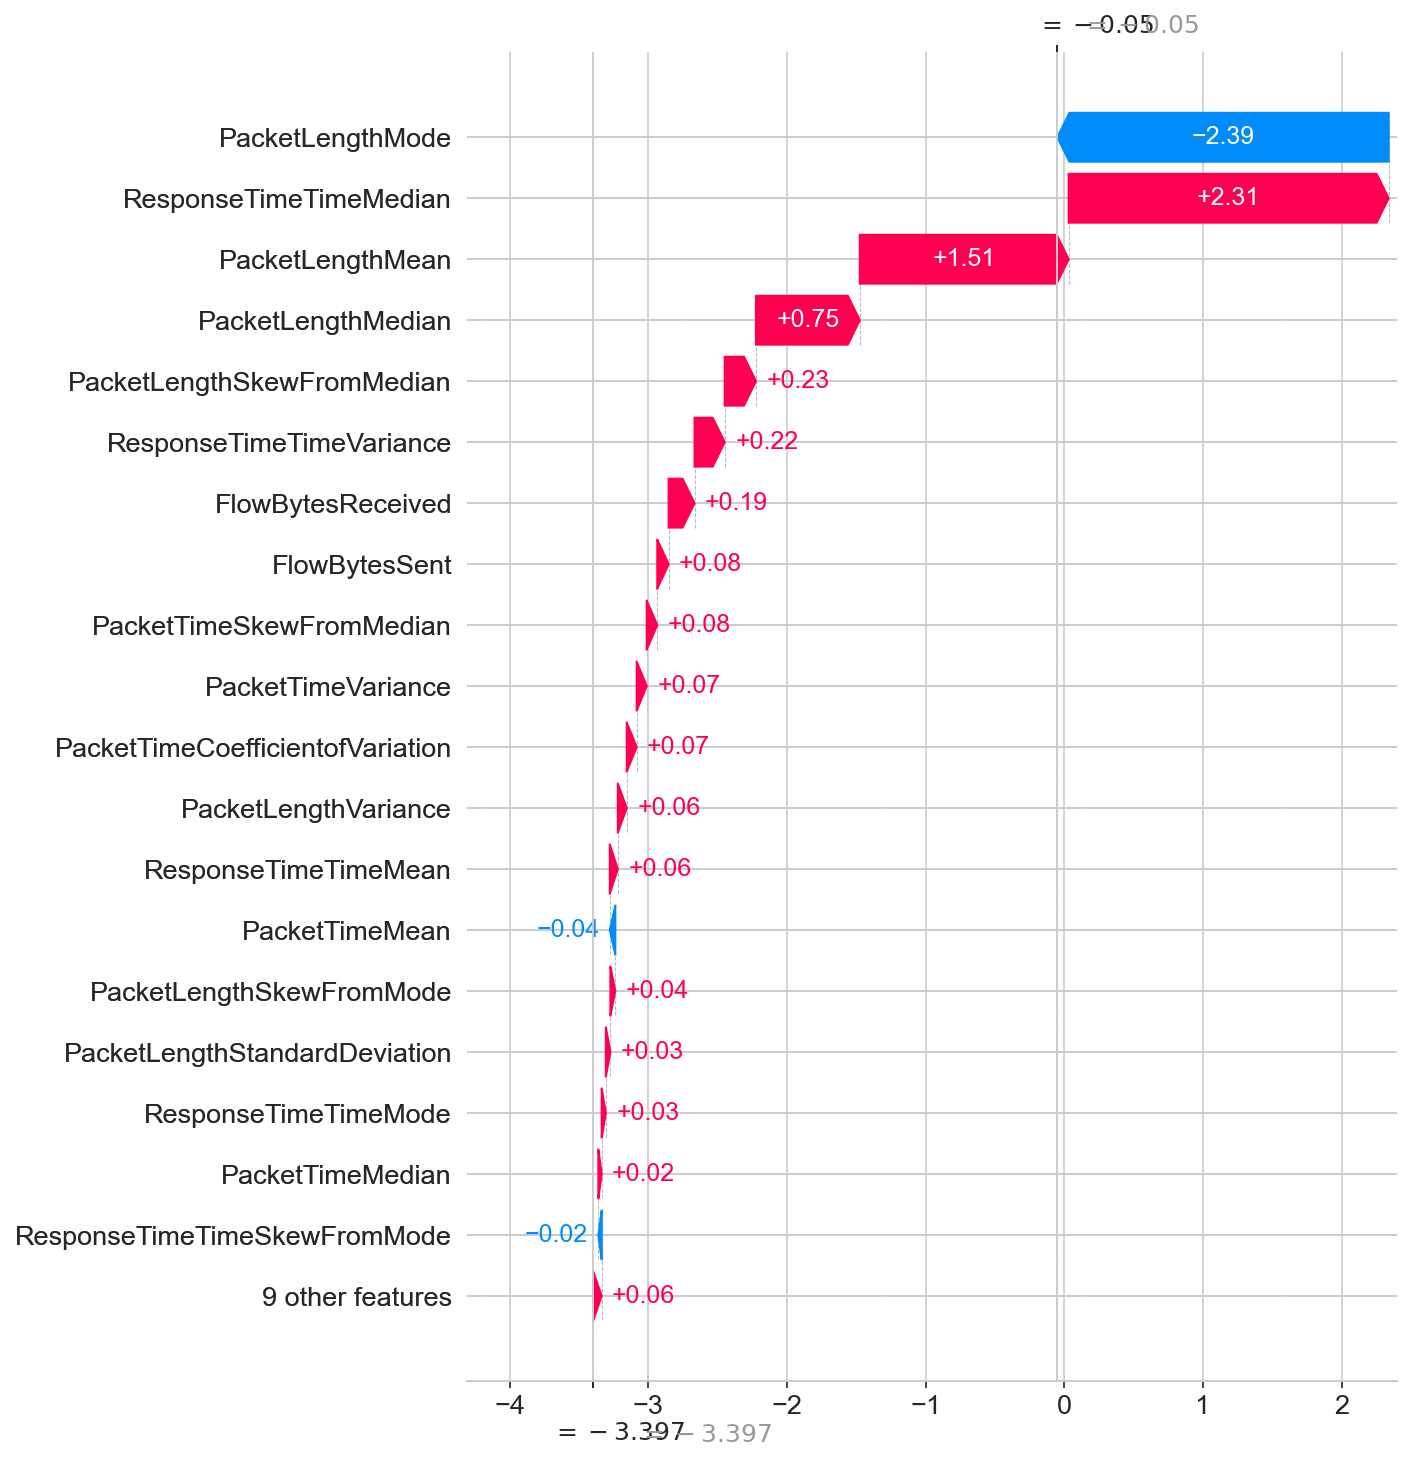

In [29]:
fig = plt.subplots(figsize=(6,6),dpi=150)
ax_3= shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][15], feature_names = test.columns,max_display = 20)

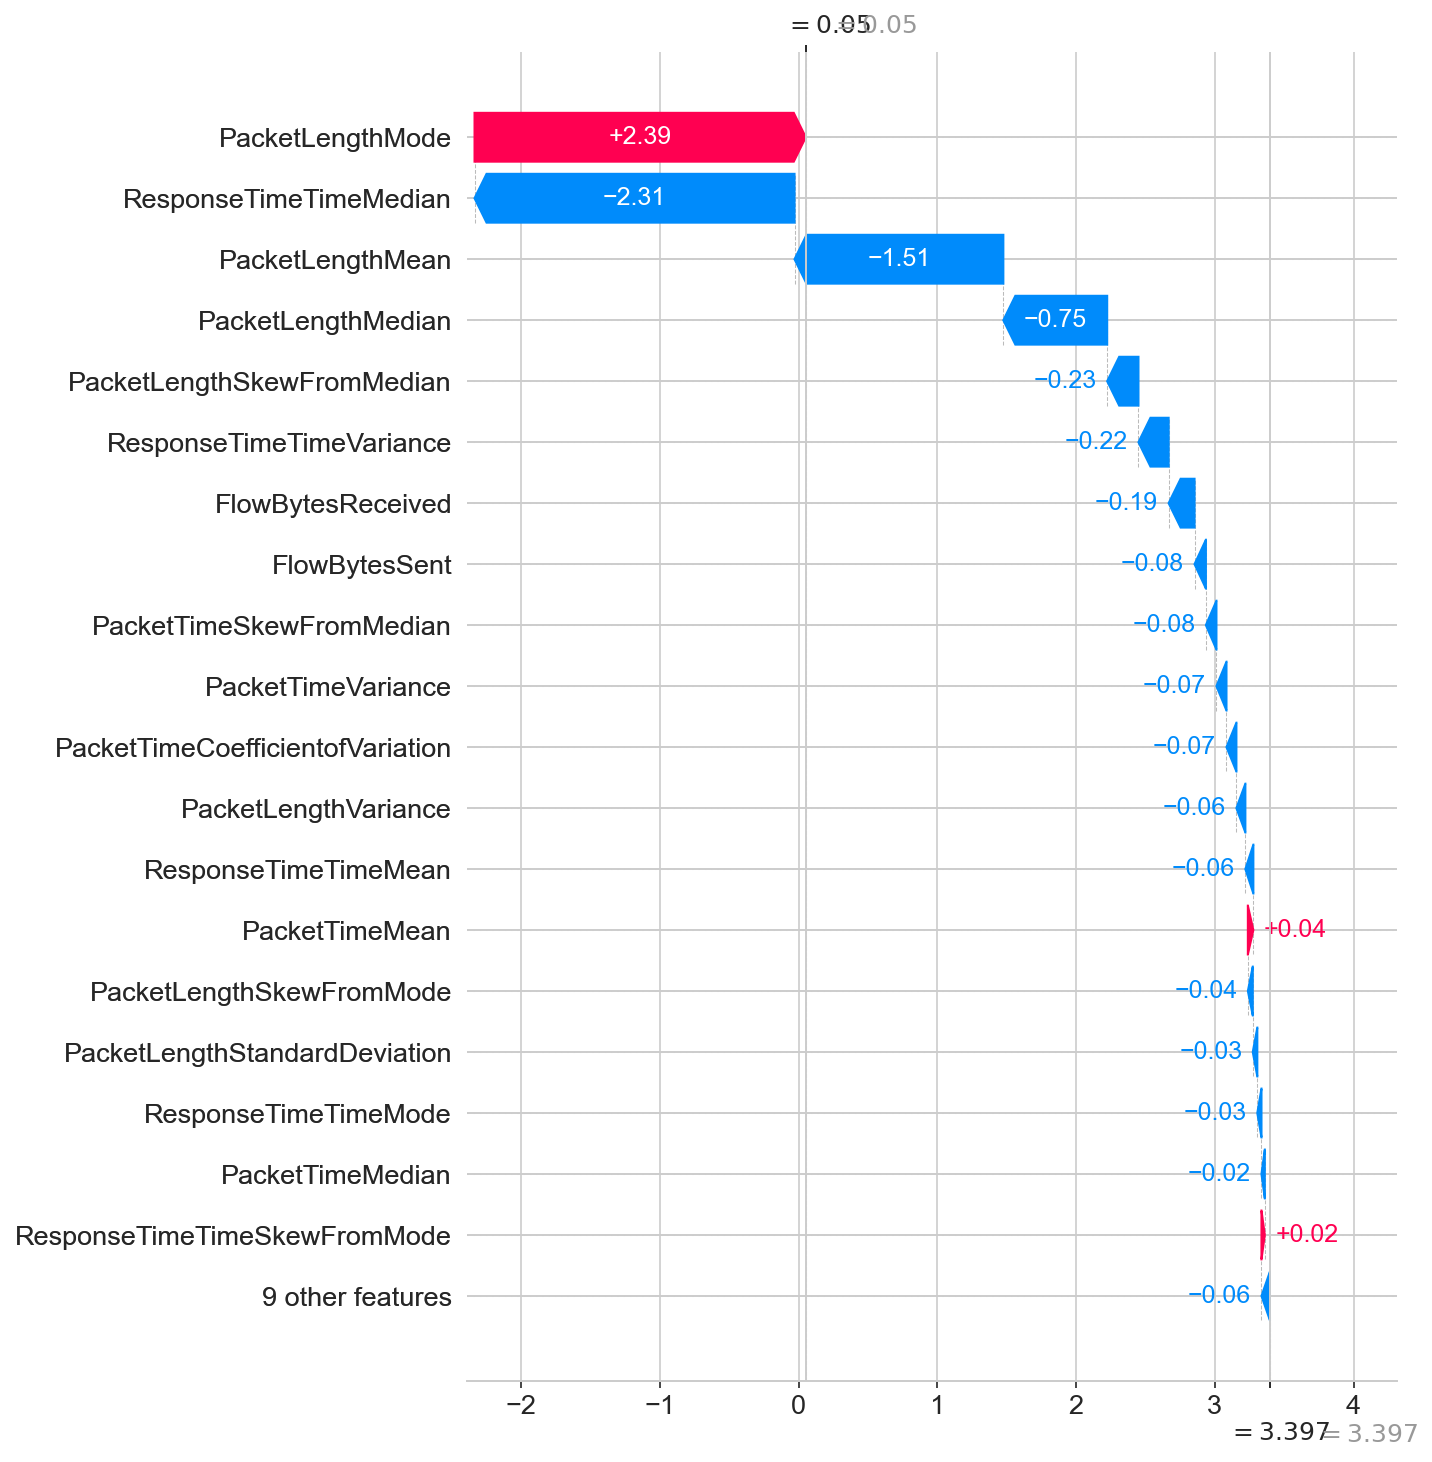

In [30]:
fig = plt.subplots(figsize=(6,6),dpi=150)
ax_3= shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][15], feature_names = test.columns,max_display = 20)

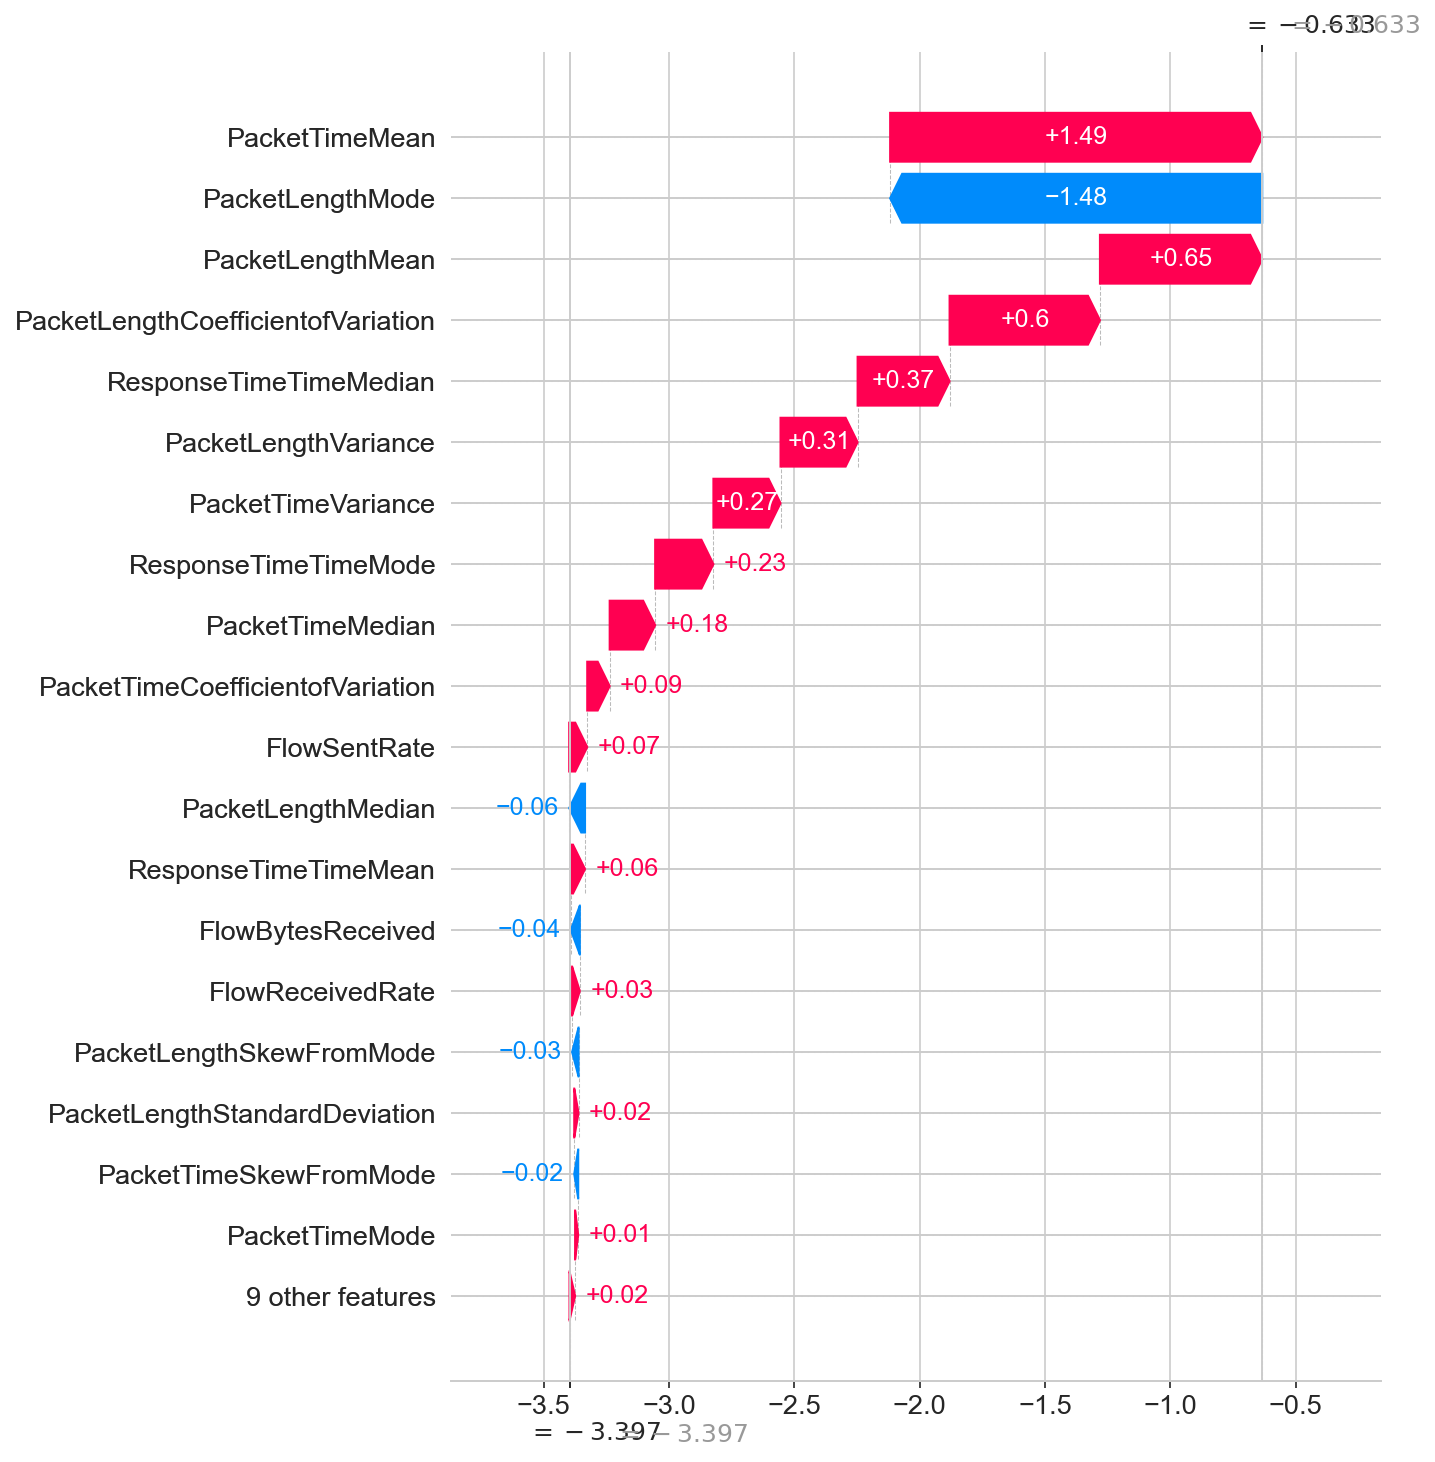

In [31]:
fig = plt.subplots(figsize=(6,6),dpi=150)
ax_3= shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][35], feature_names = test.columns,max_display = 20)

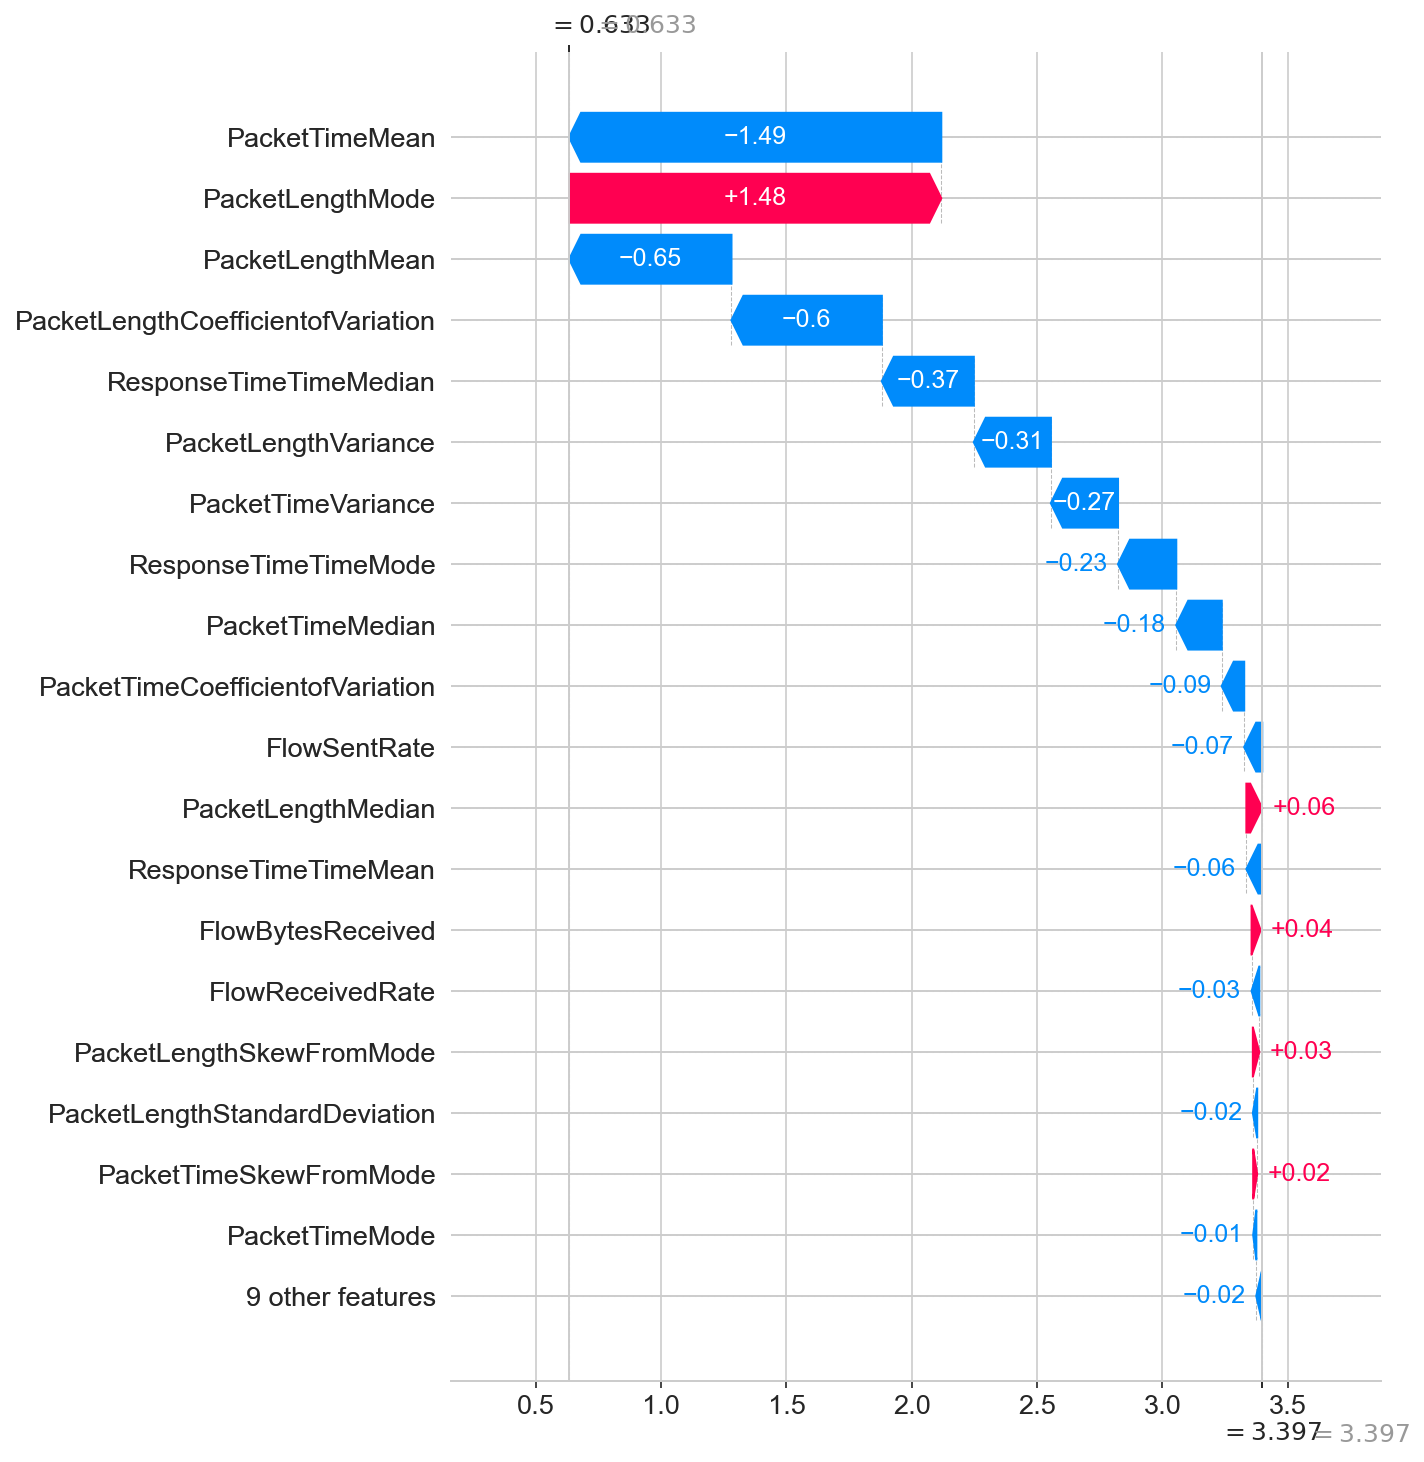

In [32]:
fig = plt.subplots(figsize=(6,6),dpi=150)
ax_3= shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][35], feature_names = test.columns,max_display = 20)